<a href="https://www.kaggle.com/code/redpolish/churn-prediction?scriptVersionId=110370471" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats 
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

In [2]:
customers = pd.read_csv('../input/brazilian-ecommerce/olist_customers_dataset.csv')
items = pd.read_csv('../input/brazilian-ecommerce/olist_order_items_dataset.csv')
payments = pd.read_csv('../input/brazilian-ecommerce/olist_order_payments_dataset.csv')
orders = pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv')

In [3]:
#only process customers with delivered package
data = customers.merge(orders, on = 'customer_id', how ='left')
data = data.merge(payments, on = 'order_id')
data = data.merge(items, on = 'order_id')
data = data[data.order_status=='delivered']
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117596,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,...,1,credit_card,6,88.78,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
117597,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,...,1,credit_card,3,129.06,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
117598,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,...,1,credit_card,5,56.04,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
117599,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,...,1,credit_card,2,711.07,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [4]:
#define churn
#cust who hadn't buy anything for 1 month
#cutoff date=2018-7-31
data['order_purchase_timestamp']=pd.to_datetime(data.order_purchase_timestamp)
data.order_purchase_timestamp.describe()

count                  115035
unique                  95955
top       2017-08-08 20:26:31
freq                       63
first     2016-10-03 09:44:50
last      2018-08-29 15:00:37
Name: order_purchase_timestamp, dtype: object

In [5]:
#purchase history
purchasehist=data[['customer_unique_id','order_purchase_timestamp']]
purchasehist

,customer_unique_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30
...,...,...
117596,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17
117597,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22
117598,e9f50caf99f032f0bf3c55141f019d99,2018-04-08 20:11:50
117599,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:08:33


In [6]:
train=purchasehist.loc[(purchasehist['order_purchase_timestamp'] <= "2018-7-31")]
train['p1'] = train.groupby('customer_unique_id')['order_purchase_timestamp'].shift(1)
train['daydiff'] = (train.order_purchase_timestamp - train.p1).dt.days
train['churn'] = train.daydiff.apply(lambda x: 1 if x > 30 else 0)
churn_id1 = set(train[train.churn == 1].customer_unique_id)

last_purchase = train.groupby('customer_unique_id')['order_purchase_timestamp'].last()
cutoff = pd.to_datetime("2018-7-31")
cutoff_daydiff = (cutoff - last_purchase).dt.days
churn = cutoff_daydiff.apply(lambda x: 1 if x > 30 else 0)
churn_id2 = set(churn[churn == 1].index)

churn_id = churn_id1.union(churn_id2)
len(churn_id)

81138

In [7]:
#customer's activity data
activitydata = data.groupby(['customer_unique_id'])['order_purchase_timestamp'].max()
activitydata = pd.DataFrame(data = activitydata).reset_index()
activitydata = activitydata.rename(columns = {'order_purchase_timestamp' : 'last_purchase'})
activitydata['last_purchase']=activitydata[['last_purchase']].apply(pd.to_datetime)
activitydata['last_active'] = (activitydata['last_purchase'].max() - activitydata['last_purchase']).dt.days
activitydata

,customer_unique_id,last_purchase,last_active
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,114
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,536
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,320
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,287
...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,446
93353,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,261
93354,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,567
93355,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,118


In [8]:
#customer orders
count_order = data.groupby('customer_unique_id')[['order_id']].count().reset_index()
avg_item = data.groupby('customer_unique_id')[['order_item_id']].mean().reset_index()
customerorder = count_order.merge(avg_item,on='customer_unique_id',how='left')
customerorder = customerorder.rename(columns = {'order_id': 'total_order', 'order_item_id': 'avg_item_ordered'})
customerorder

,customer_unique_id,total_order,avg_item_ordered
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0
2,0000f46a3911fa3c0805444483337064,1,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1.0
4,0004aac84e0df4da2b147fca70cf8255,1,1.0
...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,2,1.5
93353,fffea47cd6d3cc0a88bd621562a9d061,1,1.0
93354,ffff371b4d645b6ecea244b27531430a,1,1.0
93355,ffff5962728ec6157033ef9805bacc48,1,1.0


In [9]:
#sum of how much a customer has paid
total_spending=data.groupby('customer_unique_id')['customer_id','payment_value'].sum()
total_spending = total_spending.rename(columns = {'payment_value' : 'total_spending'}).reset_index()
total_spending

,customer_unique_id,total_spending
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84
93353,fffea47cd6d3cc0a88bd621562a9d061,84.58
93354,ffff371b4d645b6ecea244b27531430a,112.46
93355,ffff5962728ec6157033ef9805bacc48,133.69


In [10]:
#shipping
data['order_delivered_customer_date']=data[['order_delivered_customer_date']].apply(pd.to_datetime)
data['order_estimated_delivery_date']=data[['order_estimated_delivery_date']].apply(pd.to_datetime)
data['order_approved_at']=data[['order_approved_at']].apply(pd.to_datetime)
shipment = data[['customer_unique_id','order_status','order_delivered_customer_date','order_approved_at']]
shipment['shipping_days'] = (shipment['order_delivered_customer_date'] - shipment['order_approved_at']).dt.days
shipping = shipment.groupby('customer_unique_id')[['shipping_days']].mean().reset_index()
#shipping['order_delivered_customer_date']=data['order_delivered_customer_date']
#shipping['order_estimated_delivery_date']=data['order_estimated_delivery_date']
shipping['delayed_delivery']=(data.order_delivered_customer_date>data.order_estimated_delivery_date).astype(int)
shipping

,customer_unique_id,shipping_days,delayed_delivery
0,0000366f3b9a7992bf8c76cfdf3221e2,6.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.0,0.0
2,0000f46a3911fa3c0805444483337064,25.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,20.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,13.0,0.0
...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,27.0,0.0
93353,fffea47cd6d3cc0a88bd621562a9d061,30.0,0.0
93354,ffff371b4d645b6ecea244b27531430a,14.0,0.0
93355,ffff5962728ec6157033ef9805bacc48,11.0,0.0


In [11]:
#final dataset
final = shipping.merge(total_spending, on ='customer_unique_id',how='left')
final = final.merge(customerorder, on ='customer_unique_id',how='left')
final = final.merge(activitydata, on ='customer_unique_id',how='left')
final

,customer_unique_id,shipping_days,delayed_delivery,total_spending,total_order,avg_item_ordered,last_purchase,last_active
0,0000366f3b9a7992bf8c76cfdf3221e2,6.0,0.0,141.90,1,1.0,2018-05-10 10:56:27,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.0,0.0,27.19,1,1.0,2018-05-07 11:11:27,114
2,0000f46a3911fa3c0805444483337064,25.0,1.0,86.22,1,1.0,2017-03-10 21:05:03,536
3,0000f6ccb0745a6a4b88665a16c9f078,20.0,0.0,43.62,1,1.0,2017-10-12 20:29:41,320
4,0004aac84e0df4da2b147fca70cf8255,13.0,0.0,196.89,1,1.0,2017-11-14 19:45:42,287
...,...,...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,27.0,0.0,4134.84,2,1.5,2017-06-08 21:00:36,446
93353,fffea47cd6d3cc0a88bd621562a9d061,30.0,0.0,84.58,1,1.0,2017-12-10 20:07:56,261
93354,ffff371b4d645b6ecea244b27531430a,14.0,0.0,112.46,1,1.0,2017-02-07 15:49:16,567
93355,ffff5962728ec6157033ef9805bacc48,11.0,0.0,133.69,1,1.0,2018-05-02 15:17:41,118


In [12]:
final.isnull().sum()

customer_unique_id       0
shipping_days           21
delayed_delivery      2022
total_spending           0
total_order              0
avg_item_ordered         0
last_purchase            0
last_active              0
dtype: int64

In [13]:
#remove missing value
final=final.dropna()
final

,customer_unique_id,shipping_days,delayed_delivery,total_spending,total_order,avg_item_ordered,last_purchase,last_active
0,0000366f3b9a7992bf8c76cfdf3221e2,6.0,0.0,141.90,1,1.0,2018-05-10 10:56:27,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.0,0.0,27.19,1,1.0,2018-05-07 11:11:27,114
2,0000f46a3911fa3c0805444483337064,25.0,1.0,86.22,1,1.0,2017-03-10 21:05:03,536
3,0000f6ccb0745a6a4b88665a16c9f078,20.0,0.0,43.62,1,1.0,2017-10-12 20:29:41,320
4,0004aac84e0df4da2b147fca70cf8255,13.0,0.0,196.89,1,1.0,2017-11-14 19:45:42,287
...,...,...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,27.0,0.0,4134.84,2,1.5,2017-06-08 21:00:36,446
93353,fffea47cd6d3cc0a88bd621562a9d061,30.0,0.0,84.58,1,1.0,2017-12-10 20:07:56,261
93354,ffff371b4d645b6ecea244b27531430a,14.0,0.0,112.46,1,1.0,2017-02-07 15:49:16,567
93355,ffff5962728ec6157033ef9805bacc48,11.0,0.0,133.69,1,1.0,2018-05-02 15:17:41,118


In [14]:
#callibration and holding period
callibration=final.loc[(final['last_purchase'] <= "2018-7-31")]
holding=final.loc[(final['last_purchase'] > "2018-7-31")]
callibration['churn']=callibration.customer_unique_id.apply(lambda x: 1 if x in churn_id else 0)
callibration=callibration.drop(columns = ['customer_unique_id','last_purchase'])

In [15]:
#for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

In [16]:
X = callibration.drop(columns = ['churn'])
Y = callibration['churn'].values
#75% data train, 25% data test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25)

In [17]:
#KNN
knn_model = KNeighborsClassifier() 
knn_model.fit(X_train,Y_train)
knnpredicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test,Y_test)
print("KNN accuracy:",accuracy_knn)
print(classification_report(Y_test, knnpredicted_y))


#SVC
svc_model = SVC(random_state = 1)
svc_model.fit(X_train,Y_train)
svcpredicted_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_test,Y_test)
print("SVM accuracy:",accuracy_svc)
print(classification_report(Y_test, svcpredicted_y))

#RF
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, Y_train)

# Make predictions
rfpredicted_y = model_rf.predict(X_test)
print ("RF accuracy:", metrics.accuracy_score(Y_test, rfpredicted_y))
print(classification_report(Y_test, rfpredicted_y))

#LR
lr_model = LogisticRegression()
lr_model.fit(X_train,Y_train)
lrpredicted_y= lr_model.predict(X_test)
lraccuracy = lr_model.score(X_test,Y_test)
print("Logistic Regression accuracy:",lraccuracy)
print(classification_report(Y_test, lrpredicted_y))


#DT
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,Y_train)
dtpredicted_y = dt_model.predict(X_test)
accuracy_dt = dt_model.score(X_test,Y_test)
print("Decision Tree accuracy:",accuracy_dt)
print(classification_report(Y_test, dtpredicted_y))

#AdaBoost
a_model = AdaBoostClassifier()
a_model.fit(X_train,Y_train)
abpredicted_y = a_model.predict(X_test)
print("AdaBoost Classifier accuracy:",metrics.accuracy_score(Y_test, abpredicted_y))
print(classification_report(Y_test, abpredicted_y))


#GB
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
gbpredicted_y = gb.predict(X_test)
print("Gradient Boosting accuracy:", accuracy_score(Y_test, gbpredicted_y))
print(classification_report(Y_test, gbpredicted_y))

KNN accuracy: 0.996321969161126
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1420
           1       1.00      1.00      1.00     19787

    accuracy                           1.00     21207
   macro avg       0.98      0.99      0.99     21207
weighted avg       1.00      1.00      1.00     21207

SVM accuracy: 0.9929268637713963
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1420
           1       0.99      1.00      1.00     19787

    accuracy                           0.99     21207
   macro avg       0.99      0.96      0.97     21207
weighted avg       0.99      0.99      0.99     21207

RF accuracy: 0.998019521855991
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1420
           1       1.00      1.00      1.00     19787

    accuracy                           1.00     21207
   macro avg       0.99      0.9

In [18]:
holding2=holding.drop(columns=['customer_unique_id','last_purchase'])

In [19]:
#random forest has the best result
holding2['churn']=model_rf.predict(holding2)

In [20]:
holding2

,shipping_days,delayed_delivery,total_spending,total_order,avg_item_ordered,last_active,churn
20,6.0,0.0,27.75,1,1.0,8,0
32,3.0,0.0,149.64,2,1.5,26,0
36,6.0,1.0,329.62,2,1.5,4,0
50,7.0,0.0,92.18,1,1.0,20,0
88,7.0,0.0,119.32,1,1.0,23,0
...,...,...,...,...,...,...,...
93280,7.0,0.0,40.86,1,1.0,28,0
93283,4.0,0.0,147.14,1,1.0,8,0
93312,10.0,0.0,156.70,1,1.0,19,0
93332,20.0,0.0,57.98,1,1.0,26,0


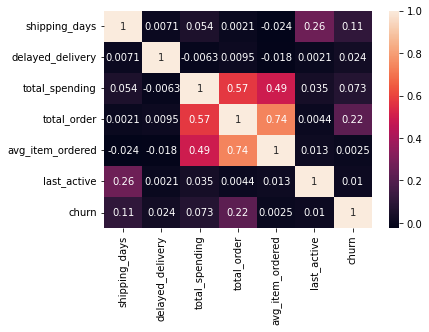

In [21]:
correlation_map=holding2.corr()
sns.heatmap(correlation_map,annot=True)
plt.show()

In [22]:
result=pd.concat([holding['customer_unique_id'],holding2],axis=1)
result

,customer_unique_id,shipping_days,delayed_delivery,total_spending,total_order,avg_item_ordered,last_active,churn
20,000ec5bff359e1c0ad76a81a45cb598f,6.0,0.0,27.75,1,1.0,8,0
32,0015752e079902b12cd00b9b7596276b,3.0,0.0,149.64,2,1.5,26,0
36,001928b561575b2821c92254a2327d06,6.0,1.0,329.62,2,1.5,4,0
50,002471155ecd08d208d1376720e2a907,7.0,0.0,92.18,1,1.0,20,0
88,00391594070baf8603f5fdc1d0c6a48c,7.0,0.0,119.32,1,1.0,23,0
...,...,...,...,...,...,...,...,...
93280,ffc39051848c3ef2be36d1513aa3ad17,7.0,0.0,40.86,1,1.0,28,0
93283,ffc4e1cd8aa220763480d0a18157c45d,4.0,0.0,147.14,1,1.0,8,0
93312,ffe204b1bb8026741b839085b2fd10f2,10.0,0.0,156.70,1,1.0,19,0
93332,ffec490ab531184a483efe2eedd68908,20.0,0.0,57.98,1,1.0,26,0


In [23]:
result['churn'].value_counts()

0    6408
1      79
Name: churn, dtype: int64